In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
from skimage.filters import threshold_otsu
from skimage.transform import resize

from preprocessing.datamodel import SlideManager
from preprocessing.processing import (
    split_negative_slide,
    split_positive_slide,
    create_tumor_mask,
    rgb2gray,
    create_otsu_mask_by_threshold,
)
from preprocessing.util import TileMap

In [ ]:
CAM16_DIR = "/storage/"
# CAM17_DIR = CAM_BASE_DIR + "data/CAMELYON17"

GENERATED_DATA = "/storage/jitbitan/outputs/cam16_heatmaps/"
CHECKPOINT = "/storage/jitbitan/outputs/inception_resnetv2_cam16.pt"

In [ ]:
sldmgr = SlideManager(cam16_dir=CAM16_DIR)

In [6]:
lvl = 3
tile_size = 256
scale_factor = 2**lvl
poi = 0.2
overlap = 100

In [7]:
print(f"Training negative slides:  {len(sldmgr.negative_slides)}")
print(f"Training annotated slides: {len(sldmgr.annotated_slides)}")
print(f"Testing slides: {len(sldmgr.test_slides)}")

Training negative slides:  160
Training annotated slides: 110
Testing slides: 129


In [6]:
from inception_resnet_v2 import InceptionResNetV2

if torch.cuda.is_available():
    inception = InceptionResNetV2().cuda()
else:
    inception = InceptionResNetV2()

inception.load_state_dict(torch.load(CHECKPOINT))

<All keys matched successfully>

In [8]:
filename = "{}all_heatmaps_tile{}_poi{}_level{}_overlap{}.hdf5".format(
    GENERATED_DATA, tile_size, poi, lvl, overlap
)

In [ ]:
def generate_heatmap(slide, lvl=6, tile_size=256, poi=0.5, overlap=0):
    slide = sldmgr.get_slide(slide)
    all_heatmaps = h5py.File(filename, "w")

    arr = np.array(slide.get_full_slide(level=lvl))
    arr_gray = rgb2gray(arr)
    thr = threshold_otsu(arr_gray)
    level_dim = slide.level_dimensions[lvl]

    tile_iter = split_negative_slide(
        slide,
        level=lvl,
        otsu_threshold=thr,
        tile_size=tile_size,
        overlap=overlap,
        poi_threshold=poi,
    )

    tm = TileMap(slide)
    heatmap = np.empty(level_dim).T
    heatmap[:] = np.nan

    mean_pixel = np.array([189.83239041, 157.00127921, 188.64640922])
    std_pixel = np.array([10.63437092, 13.99272164, 12.21288545])

    for tile, bounds in tile_iter:
        tile_arr = np.copy(tile).astype(dtype=np.float64)
        for i in range(3):
            tile_arr[:, :, i] = (tile_arr[:, :, i] - mean_pixel[i]) / std_pixel[i]
        tile_arr = np.transpose(tile_arr, (2, 0, 1))
        tile_arr = np.reshape(tile_arr, (1, 3, 256, 256))
        tile_arr = torch.FloatTensor(tile_arr).cuda()
        confidence = inception.predict_tumor(tile_arr)

        tm.add_tile(bounds)
        (x, y), (w, h) = bounds
        x = x // scale_factor
        y = y // scale_factor
        t = h // scale_factor

        tile_conf = np.empty(slide.level_dimensions[lvl])
        tile_conf[:] = np.nan
        tile_conf[x : x + t, y : y + t] = confidence

        x = np.stack((heatmap, tile_conf.T))
        heatmap = np.nanmean(x, axis=0)

    all_heatmaps.create_dataset(name=slide.name, data=np.nan_to_num(heatmap))
    all_heatmaps.close()
    plt.imshow(tm.image)

/tmp/ipykernel_68523/3880860226.py:51: RuntimeWarning: Mean of empty slice
  heatmap = np.nanmean(x, axis=0)


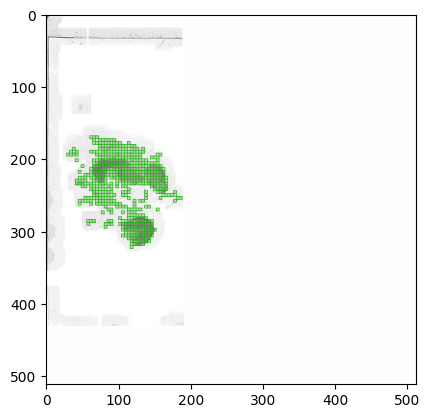

In [8]:
t_name = "tumor_011"
generate_heatmap(slide=t_name, lvl=3, tile_size=256, poi=0.2, overlap=0)

(27648, 12288)


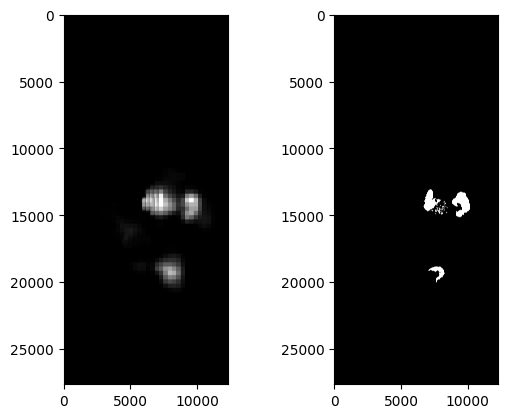

In [12]:
t_name = "tumor_011"
plt.subplot(1, 2, 1)
with h5py.File(filename, "r") as f:
    data = f[t_name][:]
    plt.imshow(data, cmap="gray")

plt.subplot(1, 2, 2)
t_slide = sldmgr.get_slide(t_name)
mask = create_tumor_mask(t_slide, level=3)
print(mask.shape)
plt.imshow(mask, cmap="gray")

In [10]:
from PIL import Image

t_slide = sldmgr.get_slide(t_name)
mask = create_tumor_mask(t_slide, level=3)
# print(mask.shape)
# plt.imshow(mask, cmap="gray")
img = Image.fromarray(mask)
img.save("test.png")

# Testing

In [9]:
t_slide = sldmgr.get_slide("tumor_011")
print(t_slide.level_dimensions[3])
# file_path = "/storage/jitbitan/outputs/cam16_tiles/all_wsi_tile256_poiNormal0.2_poiTumor0.6_level3.hdf5"

(12288, 27648)


In [ ]:
with h5py.File(filename, "r") as f:
    data = f[t_name][:]
    print(data.shape)

In [ ]:
a = np.array([[1, 2, 3], [3, 4, 2]])
b = np.array([[1, 2, 3], [3, 5, 6]])

np.maximum(a, b)

In [ ]:
t_slide = sldmgr.get_slide("normal_001")

t_slide.level_dimensions[lvl]
arr = np.array(t_slide.get_full_slide(level=lvl))
arr_gray = rgb2gray(arr)
thr = threshold_otsu(arr_gray)

tile_iter = split_negative_slide(
    t_slide,
    level=lvl,
    otsu_threshold=thr,
    tile_size=tile_size,
    overlap=overlap,
    poi_threshold=poi,
)

heatmap = np.zeros(level_dim).T

In [ ]:
for tile, bounds in tile_iter:
    tile_arr = np.copy(tile).astype(dtype=np.float64)
    for i in range(3):
        tile_arr[:, :, i] = (tile_arr[:, :, i] - mean_pixel[i]) / std_pixel[i]
    tile_arr = np.transpose(tile_arr, (2, 0, 1))
    tile_arr = np.reshape(tile_arr, (1, 3, 256, 256))
    tile_arr = torch.FloatTensor(tile_arr)
    confidence = inception.predict_tumor(tile_arr)

    (x, y), (w, h) = bounds
    x = x // scale
    y = y // scale
    t = h // scale

    tile_conf = np.zeros(slide.level_dimensions[lvl])
    tile_conf[x : x + t, y : y + t] = confidence

    heatmap = np.maximum(heatmap, tile_conf.T)

In [ ]:
plt.imshow(heatmap, cmap="gray")

In [ ]:
a = np.array(
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [2, 3, 4, 5],
    ],
    # dtype=np.float64,
)

In [ ]:
a[:, 1] = (a[:, 1] - 5.1) / 2
a

In [ ]:
plt.imshow(tm.image)

In [ ]:
j1 = np.array([[1, 2, 3], [2, 3, 4]])

j2 = np.array([[1, 2, 4], [3, 3, 4]])
np.maximum(j1, j2)

In [ ]:
a = np.zeros(t_slide.level_dimensions[5])
(x, y), (w, h) = bounds
x = x // 32
y = y // 32

a[x : x + w // 32, y : y + h // 32] = 1
plt.imshow(a.T, cmap="gray")

In [ ]:
t_slide.level_dimensions